# Navier-Stokes with a body and varying free stream

In [22]:
using ViscousFlow

In [23]:
using Plots
pyplot()
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [24]:
Re = 1000; # Reynolds number

Set the free stream motion

In [25]:
U = 1.0; # Mean free stream velocity
σx = 0.4; # amplitude of velocity fluctuation 
ϕ = -π/2  # phase lag of pitch to heave
fstar = 0.25/π # fc/U

K = π*fstar # reduced frequency, K = πfc/U

oscil = RigidBodyTools.OscilX(2π*fstar,U,U*σx,ϕ);
U∞ = RigidBodyMotion(oscil)

Rigid Body Motion:
  ċ = 0.6 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  RigidBodyTools.OscilX(0.5, 1.0, 0.4, -1.5707963267948966, Constant (0.0), AddedProfiles:
  Constant (1.0)
  0.4 × (Sinusoid (ω = 0.5) >> 3.141592653589793)
, d/dt (AddedProfiles:
  Constant (1.0)
  0.4 × (Sinusoid (ω = 0.5) >> 3.141592653589793)
))

Set up points on the body. Here is a plate:

In [26]:
n = 100;
body = Plate(1.0,n)

Plate with 100 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [27]:
cent = 1.0 + 1.0im
α₀ = -20*π/180 # angle of attack
T = RigidTransform(cent,α₀)
T(body) # transform the body to the current configuration

Plate with 100 points and length 1.0 and thickness 0.0
   Current position: (1.0,1.0)
   Current angle (rad): -0.3490658503988659


Set up the domain

In [28]:
xlim = (0.0,4.0)
ylim = (0.0,2.0)

(0.0, 2.0)

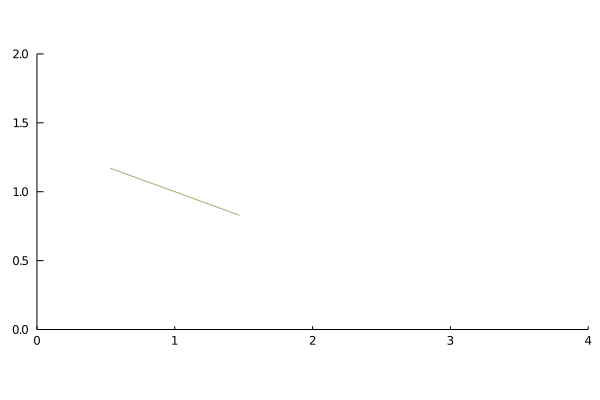

In [29]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [30]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [31]:
Δx = 0.01;
Δt = min(0.5*Δx,0.5*Δx^2*Re);

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [32]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 416 x 208

In [33]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);
xg, yg = coordinates(w₀,dx=Δx,I0=origin(sys))

(-0.075:0.01:4.075, -0.035:0.01:2.035)

Set up the integrator here

In [34]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys,U∞)
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys,U∞)

@time solver = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

  3.987314 seconds (732.97 k allocations: 3.280 GiB, 3.35% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,416,208,Float64,Array{Float64,2}}
   Force of type VectorData{100,Float64,Array{Float64,1}}
   Time step size 0.005


Initialize the state vector and the history vectors

In [35]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [36]:
tf = 1.0;
T = Δt:Δt:tf;

In [37]:
for ti in T
    global t, u, f = solver(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-6) || isapprox(mod(t,tsample),tsample,atol=1e-6)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

solution completed through time t = 1.0000000000000007


#### Plotting

Basic plot

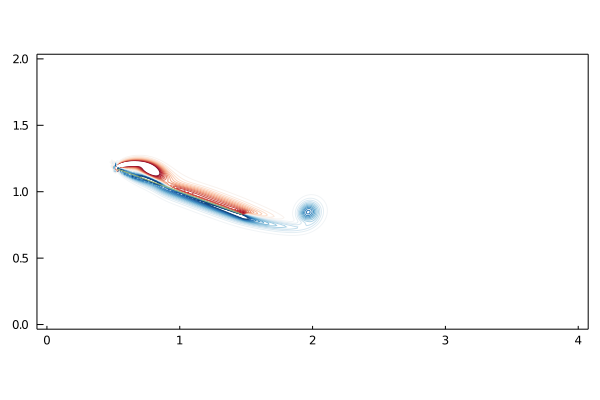

In [38]:
plot(xg,yg,vorticity(uhist[end],sys),levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15))
plot!(body)

Make a movie

┌ Info: Saved animation to 
│   fn = /home/sinan/Documents/turbulence/ViscousFlow.jl/examples/tmp.gif
└ @ Plots /home/sinan/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/home/sinan/Documents/turbulence/ViscousFlow.jl/examples/tmp.gif")
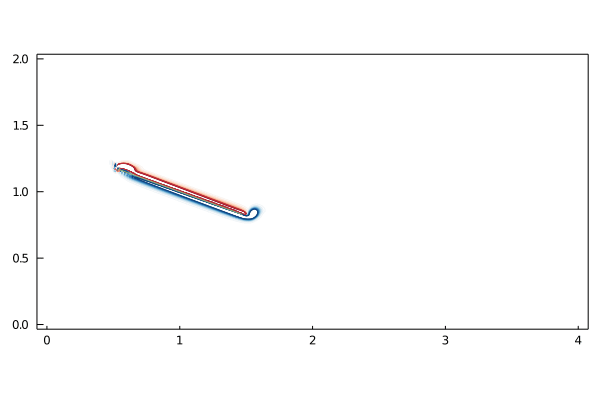

In [39]:
@gif for i = 1:length(uhist)
    plot(xg,yg,vorticity(uhist[i],sys),levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15))
    plot!(body)
end

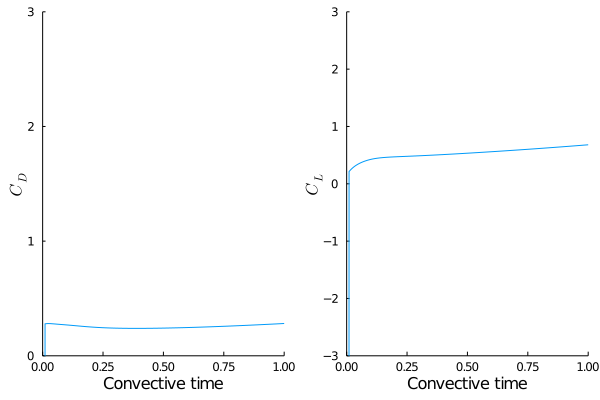

In [40]:
px = plot(thist,2*fx,xlim=(0,Inf),ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,xlim=(0,Inf),ylim=(-3,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)